# Explore pyiron-like workflows

Aim: Explore how close the presently available features of the pyiron_workflow class allow us to write pyiron-like workflows

In [1]:
%config IPCompleter.evaluation='unsafe'

import matplotlib.pylab as plt
from pyiron_workflow.workflow import Workflow

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Create structure and list available potentials

In [3]:
Workflow.register('atomistics', 'pyiron_workflow.node_library.pyiron_atomistics')
Workflow.register('lammps', 'pyiron_workflow.node_library.lammps')
Workflow.register('atomistic_codes', 'pyiron_workflow.node_library.atomistic_codes')

In [4]:
wf = Workflow('Lammps')
wf.structure = wf.create.atomistics.Bulk('Al', cubic=True)
wf.repeat = wf.create.lammps.Repeat(structure=wf.structure, repeat_scalar=1)

wf.lammps = wf.create.atomistic_codes.Lammps(structure=wf.repeat, label='lammps')
wf.lammps.list_pots()[:5]
#lammps.list_pots.pull()
#wf.run()

['1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1',
 '1996--Farkas-D--Nb-Ti-Al--LAMMPS--ipr1',
 '1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1999--Liu-X-Y--Al-Cu--LAMMPS--ipr1']

In [5]:
wf.draw(depth=2);

In [6]:
out = wf.run()
print (f'Potential energy: {wf.lammps.outputs.generic.value.energy_pot[0]}')

Potential energy: -13.4399999882896


### MD over list of temperatures

CPU times: user 828 ms, sys: 336 ms, total: 1.16 s
Wall time: 8.41 s


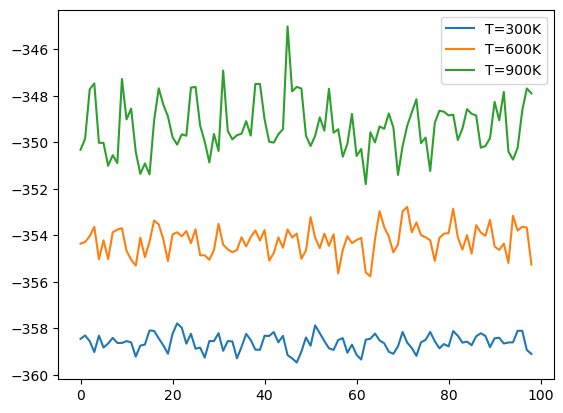

In [7]:
%%time
for T in [300, 600, 900]:
    wf = Workflow('Lammps')
    wf.structure = wf.create.atomistics.Bulk('Al', cubic=True)
    wf.repeat = wf.create.lammps.Repeat(structure=wf.structure, repeat_scalar=3)
    
    wf.lammps = wf.create.atomistic_codes.Lammps(structure=wf.repeat)
    wf.lammps.calc_select.md(temperature=T, n_ionic_steps=10_000)
    
    
    wf.run()
    
    plt.plot(wf.lammps.outputs.generic.value.energy_pot[2:], label=f'T={T}K')
plt.legend();    

In [8]:
wf.draw(depth=2);

In [9]:
wf.lammps.draw();

### Murnaghan (E-V) macro

In [10]:
# volumes = wf.create.standard.Linspace(0.9, 1.1, 11)

In [11]:
@Workflow.wrap_as.macro_node()
def energy_at_volume(wf) -> None:
    wf.bulk = wf.create.atomistics.Bulk('Al', cubic=True)
    wf.repeat = wf.create.lammps.Repeat(structure=wf.bulk, repeat_scalar=1)
    wf.apply_strain = wf.create.lammps.ApplyStrain(structure=wf.repeat, strain=1)
    
    
    wf.lammps = wf.create.atomistic_codes.Lammps(structure=wf.apply_strain)
    
    wf.inputs_map = {
        "bulk__name": "element",
        "apply_strain__strain": "strain",
        "lammps__potential_name": "potential",
    }
    wf.outputs_map = {"lammps__generic": "generic"}

In [12]:
#wf.create.iter(energy_at_volume, strain=wf.create.numpy.linspace(-0.2, 0.2, 11))

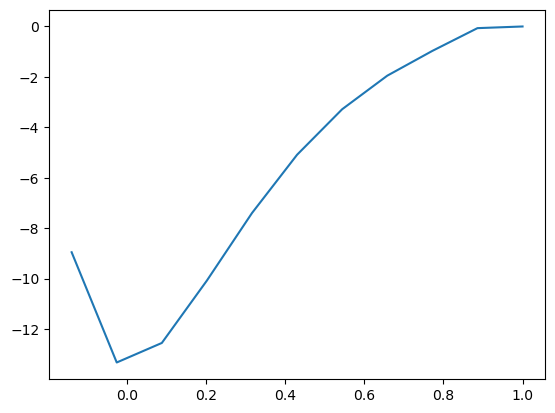

In [13]:
import numpy as np

energy_pot = []
strain_lst = np.linspace(0.86, 2, 11) - 1
for strain in strain_lst:
    wf = energy_at_volume(element='Al', strain=strain)
    out = wf.run()

    energy_pot.append(out['generic'].energy_pot[0])  

plt.plot(strain_lst, energy_pot);

### Data store

In [15]:
from pyiron_workflow.node_library.dev_tools import DataStore, node_to_data_container

In [16]:
ds = DataStore(path='DataStore')
ds.store(wf, overwrite=True)

True

In [17]:
wf_new = ds.load(wf.label)

In [18]:
wf.lammps.collect

TODO: Convert data_container to node

In [19]:
out = wf(element='Fe')

In [20]:
ds.remove(wf.label)

node energy_at_volume has been removed from store


#### Test pickle

In [21]:
import  cloudpickle as pickle

In [22]:
with open('node.pickle', 'wb') as f:
    pickle.dump(wf, f)

In [23]:
with open('node.pickle', 'rb') as f:
    new_node = pickle.load(f)

In [24]:
new_node.run();

In [25]:
new_node.outputs.generic.value.energy_pot

array([0])

In [26]:
out.generic.energy_pot

array([0])